In [1]:
import matplotlib.pyplot as plt
import control as co
import pandas as pd
import numpy as np 
import sympy as sp
import time 

from sympy.abc import a, b, q, s, z, omega, zeta
from numpy.linalg import inv

In [2]:
u, uc, vs, y, ys, Gs, Hz, Hq = sp.symbols('u(k),u_c{(k)},v(s),y(k),y(s),G(s),H(z),H(q)')
Ts = sp.symbols('T_s')

am1, am2, bm0, bm1 = sp.symbols('a_{m_1},a_{m_2},b_{m_0},b_{m_1}')
ao, a1, a2, b0, b1 = sp.symbols('a_o,a_1,a_2,b_0,b_1')
r0, s0, s1, t0, t1 = sp.symbols('r_0,s_0,s_1,t_0,t_1')

Gs_eq = sp.Eq(Gs, b/(s*(s + b)))

The model is given by {{Gs_eq}}. To discretize, 

$ G(z) =  (1-z^{-1})\mathscr{Z}\big\{\frac{b}{s^2(s+b)}\big\} $

$ G(z) =  (1-z^{-1})\mathscr{Z}\big\{\frac{1}{s^2} - \frac{1}{bs} + \frac{1}{b(b + s)} \big\} $

$ G(z) =  (1-z^{-1})\Big(\frac{T_sz}{(z-1)^2} - \frac{1}{b} \frac{z}{z-1} + \frac{1}{b} \frac{z}{z-e^{-bT_s}}\Big) $

In [3]:
Gz_eq_Ts_b = sp.simplify(sp.expand((1-1/z)*(Ts*z/(z-1)**2 - z/(b*(z-1)) + z/(b*(z-sp.exp(-b*Ts))))))

num, den = sp.fraction(Gz_eq_Ts_b)
den_poly = sp.Poly(den, z)
mono_div = den_poly.coeffs()[0]
sp.Eq(Hz, sp.collect(sp.simplify(Gz_eq_Ts_b), z))

Eq(H(z), (-T_s*b + z*(T_s*b*exp(T_s*b) - exp(T_s*b) + 1) + exp(T_s*b) - 1)/(b*(z**2*exp(T_s*b) + z*(-exp(T_s*b) - 1) + 1)))

## Pulse Function

In [4]:
radius = 38/2000  # 38 mm diameter to radius in m
mass = 4/7000  # grams per ball
area_ball = np.pi * radius**2
volume_ball = 4/3*np.pi*radius**3
density = 1.2  # kg/m^3
veq = 2.8 # m/s

Ts_val = 0.2
b_nom = 2*9.81*(mass-density*volume_ball)/(mass*veq)

In [5]:
## Example 3.1: since it has the same structure TF I used it to validate my approach, it's consistent
# sub_vals = [(Ts, Ts_val), (b, 1)]

## This is for our project
sub_vals = [(Ts, Ts_val), (b, b_nom)]

num_mono_z = sp.collect(num/mono_div, z).subs(sub_vals) 
den_mono_z = sp.collect(den/mono_div, z).subs(sub_vals) 

Hq_eq = sp.Eq(Hq, num_mono_z/den_mono_z)
Hq_eq
# np.roots(sp.Poly(num_mono_z).coeffs())

Eq(H(q), (0.0888233086497573*z + 0.0575823297146081)/(1.0*z**2 - 1.26797180817817*z + 0.267971808178173))

In [6]:
n_coeffs_nom, d_coeffs_nom = sp.fraction(Hq_eq.rhs)
pulse_coeffs = sp.Poly(d_coeffs_nom).coeffs()[1:]
for bi in sp.Poly(n_coeffs_nom).coeffs():
    pulse_coeffs.append(bi)
    
zeros = np.roots(sp.Poly(n_coeffs_nom).coeffs())
poles = np.roots(sp.Poly(d_coeffs_nom).coeffs())
zeros[0]

-0.6482794954381095

This is a sanity check with the nominal values to check the stability of the zeros. Here, the zero is unstable for a nominal value of $ b = $ {{zeros[0]}} and the poles are {{poles[0]}} and {{poles[1]}}. 

## Control Parameter Derivation

Given that the zeros are unstable, the parameters are derived without zero cancelation.  

Here we know from the compatability conditions that, 

$ \text{degA}_m = \text{degA} = 2 $

$ \text{degB}_m = \text{degB} = 1 $

Since the zeros in $ B $ are stable then $ B^+ = q + \frac{b_1}{b_0} $ and $ B^- = b_0  $

Then, 

$ \text{degA}_o = \text{degA} - \text{degB}^+ - 1 = 2 - 1 - 1 = 0 $

Using the Diophantine equation we get, 

$ AR + BS = A_oA_m $

Let $ A_o = 1$

Since the process is second order, then, 

$ \text{degR} = \text{degS} = \text{degT} = 1 $, 

with R being monic. 

### Control Parameters

In [7]:
# Process Values
_A = q**2 + a1*q + a2
_B = b0*q + b1
_Bplus = q + b1/b0
_Bminus = b0

# Model Values
_Am = q**2 + am1*q + am2
_Bm = _Am.subs(q, 1)*q
_Ao = ao

# Control Values
_R = q + r0
_S = s0*q + s1
_T = t0*q 

Diophantine equation: 

In [8]:
diophantine = sp.Eq((_A*1 + b0*_S), (_Ao*_Am))
dio_LHS_coeffs = sp.Poly(diophantine.lhs, q).coeffs()
dio_RHS_coeffs = sp.Poly(diophantine.rhs, q).coeffs()

In [9]:
for i in range(len(dio_LHS_coeffs)):
    display([dio_LHS_coeffs[i], dio_RHS_coeffs[i]])

[1, a_o]

[a_1 + b_0*s_0, a_o*a_{m_1}]

[a_2 + b_0*s_1, a_o*a_{m_2}]

#### Finding $s_0$

In [10]:
_s0 = sp.solve(dio_LHS_coeffs[1] - dio_RHS_coeffs[1], s0)[0] 
sp.Eq(s0, _s0)

Eq(s_0, (-a_1 + a_o*a_{m_1})/b_0)

#### Finding $s_1$

In [11]:
_s1 = sp.solve(dio_LHS_coeffs[2] - dio_RHS_coeffs[2], s1)[0]
sp.Eq(s1, _s1)

Eq(s_1, (-a_2 + a_o*a_{m_2})/b_0)

#### Finding T

In [12]:
_t0 = _Ao*_Bm/b0
_t0

a_o*q*(a_{m_1} + a_{m_2} + 1)/b_0

In [13]:
R = _Bplus
S = _s0*q + _s1
T = _Ao*_Bm/_Bminus

display(R)
display(S)
display(T)

q + b_1/b_0

q*(-a_1 + a_o*a_{m_1})/b_0 + (-a_2 + a_o*a_{m_2})/b_0

a_o*q*(a_{m_1} + a_{m_2} + 1)/b_0

### Control Action

In [14]:
uk1,  uck1, yk1 = sp.symbols('u(k-1),u_c{(k-1)},y(k-1)')
control_action = (sp.expand(sp.Eq((_R*u)/q, (_T*uc - _S*y)/q)))
control_action
control_subs = [(1/q*u, uk1), (1/q*uc, uck1), (1/q*y, yk1)]
control_action_sol = sp.Eq(u, sp.solve(control_action.subs(control_subs), u)[0])
control_action_sol.subs([(r0, b1/b0),
                         (s0, _s0),
                         (s1, _s1), 
                         (t0, _t0), 
                         (ao, 1)])

Eq(u(k), -b_1*u(k-1)/b_0 + q*u_c{(k)}*(a_{m_1} + a_{m_2} + 1)/b_0 - y(k)*(-a_1 + a_{m_1})/b_0 - y(k-1)*(-a_2 + a_{m_2})/b_0)

## Simulation

### Process Deivation

$ y(k) = -a_1y(k-1) - a_2y(k-2) + b_0u(k-1) + b_1u(k-2) = \phi(t-1)^T\theta $

where, 

$ \phi(t-1) = \big[-y(k-1)\ -y(k-2)\ u(k-1)\ u(k-2)\big]^T $

and 

$ \theta = \big[a_1\ a_2\ b_0\ b_1\big]^T $

In [15]:
final_time = 90
t = np.arange(0, final_time + Ts_val, Ts_val)
def reference_signal(end_time=final_time, Ts_func=Ts_val, lower_set=0.2, upper_set=0.1, period=30):
    uc_func = []
    time = np.arange(0, end_time + Ts_func, Ts_func)
    for _t in time:
        rat = 2*np.pi/period
        if np.sin(rat*_t) >= 0:
            uc_func.append(upper_set)
        else:
            uc_func.append(lower_set)
    return np.array(uc_func, float)
uc_val = reference_signal()
# plt.plot(np.arange(0, 60 + Ts_val, Ts_val), uc)
# plt.show()

In [16]:
omega_n = 1
zeta = 1
# std = 0
std = 0.001
Bmz_tf, Amz_tf = co.tfdata(co.sample_system(co.tf([1], [1, 2*zeta*omega_n, omega_n**2]), method='zoh', Ts=Ts_val))
AM1 = Amz_tf[0][0][1]
AM2 = Amz_tf[0][0][2]
# AM1 = 2*zeta*omega_n
# AM2 = omega_n**2
AM_SUM = 1 + AM1 + AM2
A0 = np.array([1])
lam = 0.98
initial_P_weights = [10000]*4
# initial_P_weights = [100, 100, 10, 10]
theta = np.array(pulse_coeffs, float).reshape(4, -1)

In [17]:
    # Estimates k = 0
time_ns = time.time_ns()
theta_hat = np.array([-0.5, 0.5, 0.25, 0.25], float).reshape(4, -1) # 0: a1 1: a2 2: b0 3: b1 
# theta_hat = np.array([-0.5, 0.5, 0.5, 0.5], float).reshape(4, -1)
# theta_hat = np.ones((4,1), float)
theta_arr = theta_hat
P = np.diag(initial_P_weights)
phi = np.zeros((4,1))

y_measure = (phi.T@theta + np.random.normal(0, std)).reshape(-1,) 

r0_est = theta_hat[3]
s0_est = A0*AM1 - theta_hat[0]
s1_est = A0*AM2 - theta_hat[1]
t0_est = A0*AM_SUM

M = np.array([r0_est, s0_est, s1_est, t0_est], float).reshape(-1, 1)
N = np.array([0, -y_measure[0], 0, uc_val[0]], float).reshape(M.shape)
u_val = 1/theta[2]*(N.T@M).reshape(-1,)

    # Estimates k = 1
phi = np.array([-y_measure[0], 0, u_val[0], 0], float).reshape(-1,1) # phi of 0
K = P@phi@inv(lam + phi.T@P@phi)
y_measure = np.concatenate((y_measure,
                            (phi.T@theta + np.random.normal(0, std)).reshape(-1,))) 
theta_hat = theta_hat + K@(y_measure[-1] - phi.T@theta_hat)
theta_arr = np.concatenate((theta_arr, 
                            theta_hat.reshape(-1, 1)), axis=1)
P = (np.eye(len(phi)) - K@phi.T) @P/lam  

r0_est = theta_hat[3]
s0_est = A0*AM1 - theta_hat[0]
s1_est = A0*AM2 - theta_hat[1]
t0_est = A0*AM_SUM

M = np.array([r0_est, s0_est, s1_est, t0_est], float).reshape(-1, 1)
N = np.array([-u_val[0], -y_measure[1], -y_measure[0], uc_val[1]],float).reshape(M.shape)
u_val = np.concatenate((u_val, 
                        1/theta[2]*(N.T@M).reshape(-1,)))

for k in range(2, len(t)):
        phi = np.array([-y_measure[k-1], -y_measure[k-2], u_val[k-1], u_val[k-2]], float).reshape(-1,1)
        K = P@phi@inv(lam + phi.T@P@phi)
        y_measure = np.concatenate((y_measure,
                                    (phi.T@theta + np.random.normal(0, std)).reshape(-1,)))    
        theta_hat = theta_hat + K@(y_measure[-1] - phi.T@theta_hat)
        theta_arr = np.concatenate((theta_arr, 
                                    theta_hat.reshape(-1, 1)), axis=1)
        P = (np.eye(len(phi)) - K@phi.T)@P/lam

        r0_est = theta_hat[3]
        s0_est = A0*AM1 - theta_hat[0]
        s1_est = A0*AM2 - theta_hat[1]
        t0_est = A0*AM_SUM

        M = np.array([r0_est, s0_est, s1_est, t0_est], float).reshape(-1, 1)
        N = np.array([-u_val[k-1], -y_measure[k], -y_measure[k-1], uc_val[k]]).reshape(M.shape)
        u_val = np.concatenate((u_val, 
                                1/theta[2]*(N.T@M).reshape(-1,)))
(time.time_ns() - time_ns)*1e-9/len(t)*1e6

77.60665188470067

In [18]:
theta_hat

array([[-1.15021054],
       [ 0.15106359],
       [ 0.0887821 ],
       [ 0.07934167]])

In [19]:
theta

array([[-1.26797181],
       [ 0.26797181],
       [ 0.08882331],
       [ 0.05758233]])

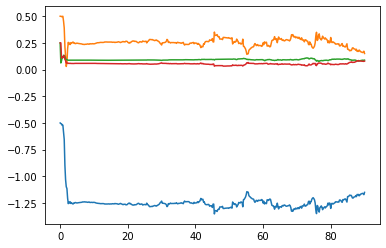

In [20]:
for row in range(len(theta_arr)):
    plt.plot(t, theta_arr[row,:])
plt.show()

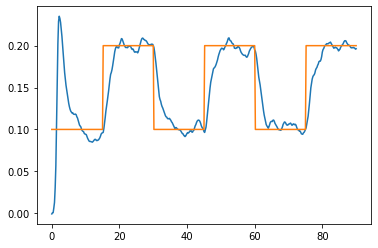

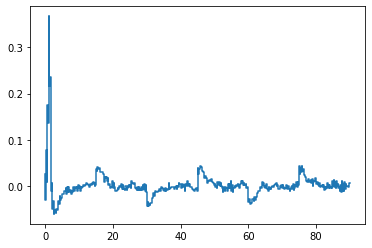

In [21]:
st = 0
et = 500 # len(t)
plt.plot(t[st:et], y_measure[st:et])
plt.plot(t[st:et], uc_val[st:et])
plt.show()
plt.step(t[st:et], u_val[st:et])
plt.show()

0.19630551607313557